"Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!"

**Data:** https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv("/users/jenny/documents/thinkful/wine data/winequality-red.csv")

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
df['quality'].max()

8

In [15]:
#binarize -- high quality as 6 or higher
df['high_quality'] = np.where(df['quality'] >= 6, 1, 0)

print('Mean:', df['high_quality'].mean())

Mean: 0.5347091932457786


In [21]:
X = df.drop(['quality', 'high_quality'], axis=1)
Y = df['high_quality']

## Neural Network

In [32]:
#100 perceptron layer
mlp = MLPClassifier(hidden_layer_sizes=(100,))
mlp.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [33]:
#cross val score
cross_val_score(mlp, X, Y, cv=5)

array([ 0.86292835,  0.86292835,  0.86520376,  0.8369906 ,  0.86520376])

In [35]:
#try with top quality
df['top_quality'] = np.where(df['quality'] >= 7, 1, 0)

L = df.drop(['quality', 'high_quality', 'top_quality'], axis=1)
M = df['top_quality']

mlp = MLPClassifier(hidden_layer_sizes=(100,))
mlp.fit(L, M)
cross_val_score(mlp, L, M, cv=5)

array([ 0.87538941,  0.86292835,  0.86520376,  0.84952978,  0.86520376])

In [40]:
#that looks better...try adding more layers

mlp2 = MLPClassifier(hidden_layer_sizes=(100, 25))
mlp.fit(L, M)

cross_val_score(mlp, L, M, cv=5)

array([ 0.87227414,  0.85669782,  0.86206897,  0.84952978,  0.86520376])

In [58]:
#less consistent with multiple layers

mlp = MLPClassifier(
    hidden_layer_sizes = (100,),
    activation = 'tanh',
    alpha = 10,
    learning_rate = 'adaptive'
)

mlp.fit(L, M)

mlp_score = cross_val_score(mlp, L, M, cv=5)
print(mlp_score)
print('\n\nMean:', mlp_score.mean())

[ 0.86292835  0.86292835  0.86520376  0.86206897  0.86520376]


Mean: 0.86366663737


After fiddling with parameters, **accuracy of about 86%** is the best we can get.


## Gradient Boosting Classifier

In [50]:
# Create training and test sets.
offset = int(L.shape[0] * 0.9)

# Put 90% of the data in the training set.
L_train, M_train = L[:offset], M[:offset]

# And put 10% in the test set.
L_test, M_test = L[offset:], M[offset:]

In [60]:
# We'll make 90 iterations, use 2-deep trees
params = {'n_estimators': 90,
          'max_depth': 3}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(L_train, M_train)

predict_train = clf.predict(L_train)
predict_test = clf.predict(L_test)

# Accuracy tables.
table_train = pd.crosstab(M_train, predict_train, margins=True)
table_test = pd.crosstab(M_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.004864489228630994
Percent Type II errors: 0.03822098679638638

Test set accuracy:
Percent Type I errors: 0.01875
Percent Type II errors: 0.06875


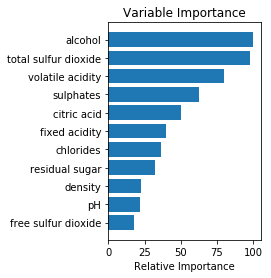

In [53]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, L.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [61]:
clf_scores = cross_val_score(clf, L, M, cv=5)
print('\nPercentage accuracy')
print(clf_scores)
print('\n\nMean:', clf_scores.mean())


Percentage accuracy
[ 0.87850467  0.85046729  0.88087774  0.8338558   0.87460815]


Mean: 0.863662731081


## Conclusion

* Both models produce a comparable accuracy (**86%**)
* The gradient boosting model allows us to look at feature relevance
* The NN has more consistent performance across folds
* The run time for the boosting model is only slightly faster than the NN for this dataset in particular